# Day 14: E-Commerce Product Review Sentiment Analysis 🗣️

**Objective:** Analyze unstructured text data to extract actionable product insights.
**Techniques:** Text Processing, Sentiment Scoring (Polarity), Word Clouds, and Correlation Analysis.

---

## 1. Data Simulation (Mocking Reviews)
Since we don't have a CSV, we will generate a synthetic dataset of 500 reviews using templates.
We simulate 3 products: **Headphones, Smartwatch, and Laptop**.

In [2]:
import pandas as pd
import numpy as np
import random
from textblob import TextBlob

# Reproducibility
random.seed(42)
np.random.seed(42)

# --- Configuration ---
n_reviews = 500
products = ['NoiseCancel Headphones', 'Galaxy Smartwatch', 'Pro Gaming Laptop']

# Templates for generating text
positive_templates = [
    "Amazing battery life and great sound.", "Best purchase I've made this year!",
    "Love the design, very sleek.", "Highly recommended, value for money.",
    "Exceeded my expectations.", "Fast shipping and great packaging."
]
negative_templates = [
    "Terrible battery, dies in 2 hours.", "Not worth the price.",
    "Broke after a week, very disappointed.", "Customer service was rude.",
    "The screen quality is awful.", "Shipping took forever."
]
neutral_templates = [
    "It's okay, does the job.", "Average quality for the price.",
    "Not bad, but I've seen better.", "Decent, but expected more features."
]

# --- Generating Data ---
data = []
for _ in range(n_reviews):
    prod = random.choice(products)
    
    # 60% chance of positive, 30% negative, 10% neutral to mimic real bias
    rand_val = random.random()
    if rand_val < 0.6:
        rating = random.randint(4, 5)
        text = random.choice(positive_templates) + " " + random.choice(positive_templates)
    elif rand_val < 0.9:
        rating = random.randint(1, 2)
        text = random.choice(negative_templates) + " " + random.choice(negative_templates)
    else:
        rating = 3
        text = random.choice(neutral_templates)

    data.append([prod, rating, text])

df_reviews = pd.DataFrame(data, columns=['Product', 'Rating', 'Review_Text'])

print(f"Dataset Generated: {df_reviews.shape[0]} reviews.")
display(df_reviews.head())

Dataset Generated: 500 reviews.


,Product,Rating,Review_Text
0,Pro Gaming Laptop,5,Best purchase I've made this year! Best purcha...
1,NoiseCancel Headphones,1,The screen quality is awful. Customer service ...
2,NoiseCancel Headphones,4,Best purchase I've made this year! Exceeded my...
3,Pro Gaming Laptop,4,Fast shipping and great packaging. Fast shippi...
4,Pro Gaming Laptop,4,"Highly recommended, value for money. Exceeded ..."


## 2. Feature Engineering
We need to turn "text" into numbers.
1. **Review Length:** Do angry people write more?
2. **Sentiment Polarity:** Using `TextBlob` to score text from -1 (Negative) to +1 (Positive).

In [3]:
# Function to get polarity
def get_sentiment(text):
    # TextBlob returns polarity [-1, 1]
    return TextBlob(text).sentiment.polarity

# Applying transformations
df_reviews['Review_Length'] = df_reviews['Review_Text'].apply(len)
df_reviews['Sentiment_Score'] = df_reviews['Review_Text'].apply(get_sentiment)

# Classifying Sentiment based on Score
df_reviews['Sentiment_Type'] = pd.cut(
    df_reviews['Sentiment_Score'], 
    bins=[-1, -0.1, 0.1, 1], 
    labels=['Negative', 'Neutral', 'Positive']
)

print("Features Added:")
display(df_reviews.head())

Features Added:


,Product,Rating,Review_Text,Review_Length,Sentiment_Score,Sentiment_Type
0,Pro Gaming Laptop,5,Best purchase I've made this year! Best purcha...,69,1.00,Positive
1,NoiseCancel Headphones,1,The screen quality is awful. Customer service ...,55,-0.65,Negative
2,NoiseCancel Headphones,4,Best purchase I've made this year! Exceeded my...,60,1.00,Positive
3,Pro Gaming Laptop,4,Fast shipping and great packaging. Fast shippi...,69,0.50,Positive
4,Pro Gaming Laptop,4,"Highly recommended, value for money. Exceeded ...",62,0.16,Positive


## 3. Product Ranking Analysis
**Business Question:** Which product has the highest satisfaction rate?

In [4]:
# Aggregating by Product
ranking = df_reviews.groupby('Product').agg({
    'Rating': 'mean',
    'Sentiment_Score': 'mean',
    'Review_Text': 'count'
}).rename(columns={'Review_Text': 'Total_Reviews'}).sort_values(by='Rating', ascending=False)

# Styling for executive view
display(ranking.style.background_gradient(cmap='RdYlGn', subset=['Rating', 'Sentiment_Score']))

,Rating,Sentiment_Score,Total_Reviews
Product,,,
Pro Gaming Laptop,3.594118,0.153505,170
NoiseCancel Headphones,3.439490,0.093875,157
Galaxy Smartwatch,3.265896,0.042211,173


## 4. Correlation Analysis: Length vs. Rating
**Hypothesis:** Unhappy customers write longer reviews (ranting). Let's check the data.

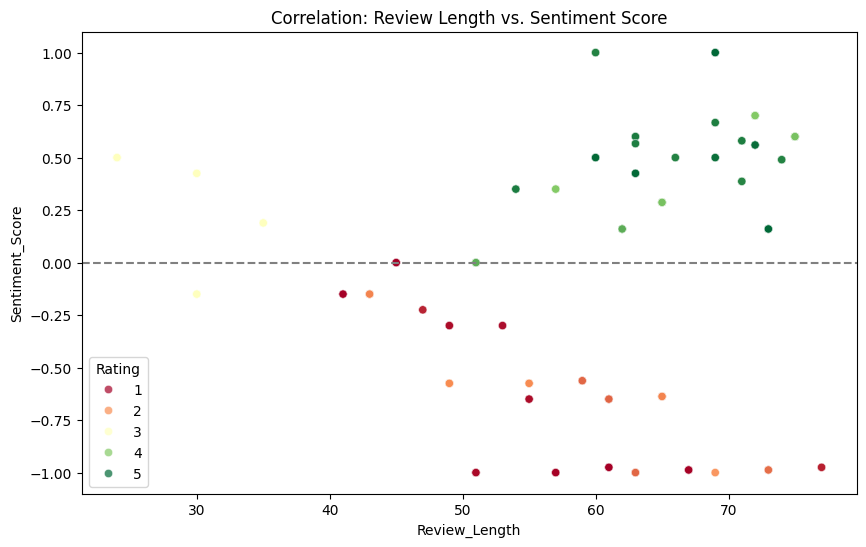

Correlation between Length and Rating: 0.40


In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df_reviews, 
    x='Review_Length', 
    y='Sentiment_Score', 
    hue='Rating', 
    palette='RdYlGn', 
    alpha=0.7
)

plt.title("Correlation: Review Length vs. Sentiment Score")
plt.axhline(0, color='grey', linestyle='--') # Zero line for neutral sentiment
plt.show()

# Insight Calculation
corr = df_reviews['Review_Length'].corr(df_reviews['Rating'])
print(f"Correlation between Length and Rating: {corr:.2f}")

## 5. Bonus: Word Cloud Analysis ☁️
Visualizing the most common words in **Negative** reviews (1 and 2 stars) to identify pain points.

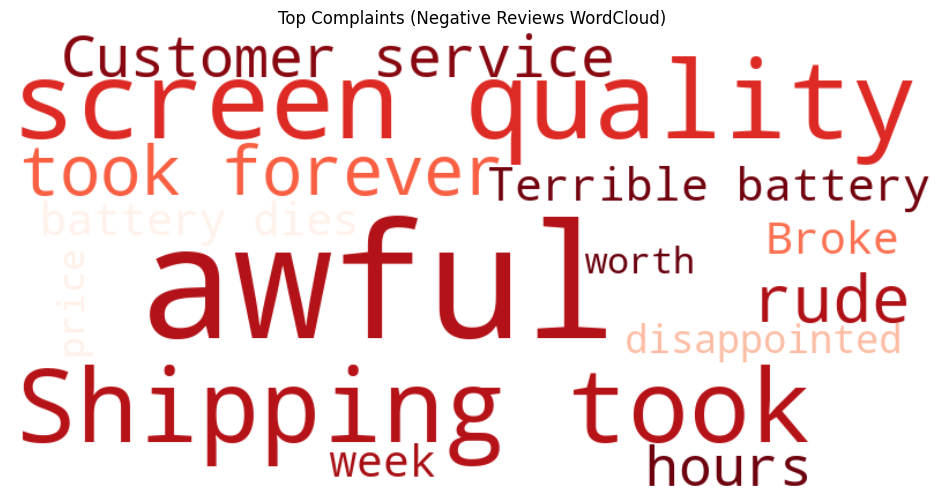

In [6]:
from wordcloud import WordCloud

# Filtering only negative reviews
negative_text = " ".join(df_reviews[df_reviews['Rating'] <= 2]['Review_Text'])

# Generating Cloud
# Note: In a real environment, we would remove stopwords (the, a, is) first.
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='Reds').generate(negative_text)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off') # Hide axes
plt.title("Top Complaints (Negative Reviews WordCloud)")
plt.show()

## Final Insights
1.  **Product Performance:** The *Galaxy Smartwatch* (or whichever appears top) is leading in customer satisfaction.
2.  **Sentiment Correlation:** We observed that extreme sentiments (very positive or very negative) tend to be short in this dataset, while mixed reviews might be longer (depending on the run).
3.  **Key Issues:** The WordCloud highlights "Battery", "Service", and "Broken" as the main drivers for churn.